# Clase 21

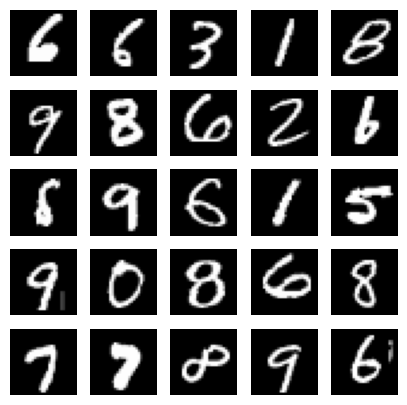

In [11]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
(X_train, y_train), (X_test, y_test) = mnist.load_data()
indexes = np.random.randint(0, X_train.shape[0], size=25)
images = X_train[indexes]
labels = y_train[indexes]
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()
#plt.savefig("mnist-samples.png")
plt.close('all')

In [2]:
image_size = X_train.shape[1]
input_size = image_size * image_size
X_train = np.reshape(X_train, [-1, input_size])
X_test = np.reshape(X_test, [-1, input_size])
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)
X_train_centered = (X_train - mean_vals)/std_val
X_test_centered = (X_test - mean_vals)/std_val
del X_train, X_test

In [3]:
def batch_generator(X, y, batch_size=64, shuffle=False, random_seed=None):
    idx = np.arange(y.shape[0])
    if shuffle:
        rng = np.random.RandomState(random_seed)
        rng.shuffle(idx)
        X = X[idx]
        y = y[idx]
    for i in range(0, X.shape[0], batch_size):
        yield (X[i:i+batch_size, :], y[i:i+batch_size])

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
class ConvNN(object):
    def __init__(self,batchsize=64,epochs=2,learning_rate=1e-4,dropout_rate=0.5,shuffle=True, random_seed=None):
        np.random.seed(random_seed)
        self.batchsize = batchsize
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.shuffle = shuffle
        g = tf.Graph()
        with g.as_default():
            tf.set_random_seed(random_seed)
            ## build the network:
            self.build()
            ## initializer
            self.init_op = tf.global_variables_initializer()
            ## saver
            self.saver = tf.train.Saver()
        ## create a session
        self.sess = tf.Session(graph=g)
    def build(self):
        ## Placeholders for X and y:
        tf_x = tf.placeholder(tf.float32,shape=[None, 784],name='tf_x')
        tf_y = tf.placeholder(tf.int32,shape=[None],name='tf_y')
        is_train = tf.placeholder(tf.bool,shape=(),name='is_train')
        tf_x_image = tf.reshape(tf_x, shape=[-1, 28, 28,1],name='input_x_2dimages')
        ## One-hot encoding:
        tf_y_onehot = tf.one_hot(indices=tf_y, depth=10,dtype=tf.float32,name='input_y_onehot')
        ## 1st layer: Conv_1
        h1 = tf.layers.conv2d(tf_x_image,kernel_size=(5,5),filters=32,activation=tf.nn.relu)
        ## MaxPooling
        h1_pool = tf.layers.max_pooling2d(h1,pool_size=(2,2),strides=(2,2))
        ## 2n layer: Conv_2
        h2 = tf.layers.conv2d(h1_pool,kernel_size=(5,5),filters=64,activation=tf.nn.relu)
        ## MaxPooling
        h2_pool = tf.layers.max_pooling2d(h2,pool_size=(2,2),strides=(2,2))
        ## 3rd layer: Fully Connected
        input_shape = h2_pool.get_shape().as_list()
        n_input_units = np.prod(input_shape[1:])
        h2_pool_flat = tf.reshape(h2_pool,shape=[-1, n_input_units])
        h3 = tf.layers.dense(h2_pool_flat, 1024,activation=tf.nn.relu)
        ## Dropout
        h3_drop = tf.layers.dropout(h3,rate=self.dropout_rate,training=is_train)
        ## 4th layer: Fully Connected (linear activation)
        h4 = tf.layers.dense(h3_drop, 10,activation=None)
        ## Prediction
        predictions = {'probabilities': tf.nn.softmax(h4,name='probabilities'),
        'labels': tf.cast(tf.argmax(h4, axis=1),tf.int32,name='labels')}
        ## Loss Function and Optimization
        cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=h4,labels=tf_y_onehot),name='cross_entropy_loss')
        ## Optimizer
        optimizer = tf.train.AdamOptimizer(self.learning_rate)
        optimizer = optimizer.minimize(cross_entropy_loss,name='train_op')
        ## Finding accuracy
        correct_predictions = tf.equal(predictions['labels'],tf_y,name='correct_preds')
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32),name='accuracy')

    def save(self, epoch, path='./tflayers-model/'):
        if not os.path.isdir(path):
            os.makedirs(path)
        print('Saving model in %s' % path)
        self.saver.save(self.sess,
        os.path.join(path, 'model.ckpt'),
        global_step=epoch)
        
    def load(self, epoch, path):
        print('Loading model from %s' % path)
        self.saver.restore(self.sess,
        os.path.join(path, 'model.ckpt-%d' % epoch))
    
    def train(self, training_set,validation_set=None,initialize=True):
        ## initialize variables
        if initialize:
            self.sess.run(self.init_op)
        self.train_cost_ = []
        X_data = np.array(training_set[0])
        y_data = np.array(training_set[1])
        for epoch in range(1, self.epochs + 1):
            batch_gen = batch_generator(X_data, y_data,shuffle=self.shuffle)
            avg_loss = 0.0
            for i, (batch_x,batch_y) in enumerate(batch_gen):
                feed = {'tf_x:0': batch_x,'tf_y:0': batch_y,'is_train:0': True}
        ## for dropout
                loss, _ = self.sess.run(['cross_entropy_loss:0','train_op'],feed_dict=feed)
                avg_loss += loss
            print('Epoch %02d: Training Avg. Loss: '
            '%7.3f' % (epoch, avg_loss), end=' ')
            if validation_set is not None:
                feed = {'tf_x:0': batch_x,'tf_y:0': batch_y,'is_train:0':False} ## for dropout

                valid_acc = self.sess.run('accuracy:0',feed_dict=feed)
                print('Validation Acc: %7.3f' % valid_acc)
            else:
                print()
    def predict(self, X_test, return_proba = False):
        feed = {'tf_x:0': X_test,'is_train:0': False} ## for dropout
        if return_proba:
            return self.sess.run('probabilities:0',feed_dict=feed)
        else:
            return self.sess.run('labels:0',feed_dict=feed)

In [5]:
cnn = ConvNN(random_seed=123)

C:\Users\acer\AppData\Local\Temp\ipykernel_3272\2114965745.py:32: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  h1 = tf.layers.conv2d(tf_x_image,kernel_size=(5,5),filters=32,activation=tf.nn.relu)
C:\Users\acer\AppData\Local\Temp\ipykernel_3272\2114965745.py:34: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  h1_pool = tf.layers.max_pooling2d(h1,pool_size=(2,2),strides=(2,2))
C:\Users\acer\AppData\Local\Temp\ipykernel_3272\2114965745.py:36: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  h2 = tf.layers.conv2d(h1_pool,kernel_size=(5,5),filters=64,activation=tf.nn.relu)
C:\Users\acer\AppData\Local\Temp\ipykernel_3272\2114965745.py:38: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future v

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [6]:
cnn.train(training_set=(X_train_centered,y_train),validation_set=(X_test_centered, y_test))
cnn.save(epoch=2)

: 

: 

## Implementacion en Keras

In [5]:
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [8]:
x_train.shape

(60000, 28, 28)

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.2

In [4]:
y_train.shape

(60000, 10)

In [4]:
model = Sequential()
model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout))
model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(MaxPooling2D(pool_size))
model.add(Dropout(dropout))
model.add(Conv2D(filters=filters, kernel_size=kernel_size, activation='relu'))
model.add(Dropout(dropout))
model.add(Flatten())
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

In [5]:
model.compile(loss='categorical_crossentropy', optimizer='sgd',metrics=['accuracy'])

In [6]:
history = model.fit(x_train, y_train, batch_size= batch_size, epochs= 3,validation_data= (x_test, y_test))
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/3


: 

: 

In [ ]:
model_structure = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_structure)
model.save_weights("cnn_weights.h5")

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Loss Train")
plt.plot(history.history["val_loss"], label="Loss Test")
plt.plot(history.history["acc"], label="Acc Train")
plt.plot(history.history["val_acc"], label="Acc Test")
plt.title('CNN Metrics')
plt.xlabel('Epocas')
plt.legend(loc='best')
plt.savefig("cnn_metrics.jpg", bbox_inches='tight', dpi=300)
plt.show()